# **Car Insurance Claims**

## **Intall & Load Libraries**

**Change Log**

1. Remove policy_date_renewal_date column since same with expiry.
2. Remove the categorize apply functions from value mappings.
3. Create new binary column matching driver age and policy holder age.
4. Postal Codes, first digit categorized and new value counts column created.


In [56]:
# Import packages

#!pip install category-encoders

## General 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output 
pd.options.display.max_rows = 200

## Data Cleaning
from sklearn.impute import SimpleImputer
from sklearn_pandas import CategoricalImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.preprocessing import StandardScaler
from category_encoders.one_hot import OneHotEncoder

try:
  import featuretools as ft
except:
  !pip install featuretools
finally:
  import featuretools as ft

## Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

try: 
  import optuna
except:
  !pip install optuna
finally:
  import optuna

import lightgbm as lgb

## Evaluation 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import uniform
from sklearn import metrics

## Warnings

import warnings
warnings.filterwarnings("ignore")

clear_output()
print("All packages loaded successfully")

All packages loaded successfully


In [42]:
# Load the datasets

!wget -O 'train.csv' http://seppe.net/aa/assignment1/data/train.csv
!wget -O 'test.csv' http://seppe.net/aa/assignment1/data/test.csv
train_dataframe = pd.read_csv('train.csv', sep=';') 
test_dataframe =  pd.read_csv('test.csv', sep=';') 
clear_output()
print("Data loaded successfully as <train_dataframe> and <test_dataframe>")

Data loaded successfully as <train_dataframe> and <test_dataframe>


## **Exploratory Data Analysis (EDA)**

In [43]:
# Drop more than 90% missing columns

train_dataframe = pd.read_csv('train.csv', sep=';') 
test_dataframe =  pd.read_csv('test.csv', sep=';') 
missing_fractions = (train_dataframe.isnull().sum()/train_dataframe.shape[0]).sort_values(ascending=False) 
columns_to_drop = missing_fractions[missing_fractions > 0.9].index.tolist()
columns_to_drop.remove("third_party_3_injured")
columns_to_drop.remove("third_party_3_form")
columns_to_drop.remove("third_party_2_form")
columns_to_drop.remove("third_party_2_injured")
columns_to_drop.remove("third_party_1_expert_id")
columns_to_drop.remove("third_party_2_expert_id")
columns_to_drop.remove("claim_alcohol")
train_dataframe = train_dataframe.drop(columns_to_drop, axis = 1)
test_dataframe = test_dataframe.drop(columns_to_drop, axis = 1)

In [33]:
# Explore the columns

for column in train_dataframe.columns.tolist():
  print(column.ljust(27), ":", str(train_dataframe[column].value_counts().shape[0]).ljust(10), "-", "Type: ", 
          str(train_dataframe[column].dtype).ljust(10), "-","Missing: ", str(train_dataframe[column].isna().sum()).ljust(10),"-", "First Instance: ", train_dataframe[column][0])
  
print(train_dataframe['fraud'].value_counts())
print(train_dataframe['fraud'].value_counts(normalize=True) * 100)

claim_id                    : 55463      - Type:  int64      - Missing:  0          - First Instance:  10000
fraud                       : 2          - Type:  object     - Missing:  0          - First Instance:  N
claim_amount                : 48731      - Type:  object     - Missing:  0          - First Instance:  4895,00
claim_date_registered       : 332        - Type:  int64      - Missing:  0          - First Instance:  20170101
claim_date_occured          : 793        - Type:  int64      - Missing:  0          - First Instance:  20161229
claim_time_occured          : 49         - Type:  float64    - Missing:  49010      - First Instance:  nan
claim_postal_code           : 1060       - Type:  int64      - Missing:  0          - First Instance:  2018
claim_cause                 : 8          - Type:  object     - Missing:  0          - First Instance:  traffic accident
claim_liable                : 2          - Type:  object     - Missing:  0          - First Instance:  Y
claim_num_i

## **Feature Engineering**

In [ ]:
# Feature tools - Numeric synthesis

es = ft.EntitySet(id = 'claim')
es.entity_from_dataframe(entity_id = 'data', dataframe = train_dataframe, 
                     make_index = True, index = 'index')

# Run deep feature synthesis with transformation primitives
train_dataframe, feature_defs = ft.dfs(entityset = es, target_entity = 'data',
                                  trans_primitives = ['multiply_numeric'])

et = ft.EntitySet(id = 'claim')
et.entity_from_dataframe(entity_id = 'data', dataframe = test_dataframe, 
                     make_index = True, index = 'index')

# Run deep feature synthesis with transformation primitives
test_dataframe, feature_defs = ft.dfs(entityset = et, target_entity = 'data',
                                  trans_primitives = ['multiply_numeric'])

In [44]:
# Convert & Group Columns Sequentially

## Train

train_dataframe = train_dataframe.drop('claim_id', axis=1)

#To datetime
train_dataframe['claim_date_registered'] = train_dataframe["claim_date_registered"].apply(lambda z: pd.to_datetime(z, format='%Y%m%d', errors='ignore'))
train_dataframe['claim_date_occured'] = train_dataframe["claim_date_occured"].apply(lambda z: pd.to_datetime(z, format='%Y%m%d', errors='ignore'))
train_dataframe['claim_time_occured'] = train_dataframe['claim_time_occured'].apply(lambda z: int(str(
    pd.to_datetime(z, format='%h%m', errors='ignore')).zfill(4)[0:2]) if (not pd.isna(z)) else np.nan)

#only taking first number of postal code
train_dataframe['claim_postal_code'] = train_dataframe['claim_postal_code'].apply(lambda z: int(str(z)[0:2]) if (not pd.isnull(z)) else 0)

# If more than 2 veichle_id issued, assign 1, else assign 0
train_dataframe['claim_vehicle_id'] = train_dataframe['claim_vehicle_id'].map(train_dataframe.claim_vehicle_id.value_counts()).apply(lambda z: 1 if(z>2) else 0)

#To date
train_dataframe["claim_vehicle_date_inuse"] = train_dataframe["claim_vehicle_date_inuse"].apply(lambda z: pd.to_datetime(z, format='%Y%m', errors='ignore'))

train_dataframe['policy_holder_id'] = train_dataframe['policy_holder_id'].map(train_dataframe.policy_holder_id.value_counts()).apply(lambda z: 1 if(z>2) else 0)
#train_dataframe['policy_holder_postal_code'] = train_dataframe['policy_holder_postal_code'].apply(lambda z: int(str(z)[0:2]) if (not pd.isnull(z)) else 0)

#Birthdate to age
train_dataframe['policy_holder_year_birth'] = train_dataframe['policy_holder_year_birth'].apply(lambda z: 2017-z)

#Change policy_order_expert_id to 'high', 'medium', 'low' based on value counts
train_dataframe['policy_holder_expert_id'] = train_dataframe['policy_holder_expert_id'].map(train_dataframe.policy_holder_expert_id.value_counts(1)).apply(
    lambda z: 'high' if(z>0.03) else ('medium' if (z>0.001) else 'low'))

train_dataframe['driver_id'] = train_dataframe['driver_id'].map(train_dataframe.driver_id.value_counts()).apply(lambda z: 1 if(z>2) else 0)
train_dataframe['driver_postal_code'] = train_dataframe['driver_postal_code'].apply(lambda z: int(str(z)[0:2]) if (not pd.isnull(z)) else 0)
train_dataframe['driver_year_birth'] = train_dataframe['driver_year_birth'].apply(lambda z: 2017-z)
train_dataframe['driver_expert_id'] = train_dataframe['driver_expert_id'].map(train_dataframe.driver_expert_id.value_counts(1)).apply(
    lambda z: 'high' if(z>0.03) else ('medium' if (z>0.001) else 'low'))
#train_dataframe['driver_vehicle_id'] = train_dataframe['driver_vehicle_id'].map(train_dataframe.driver_vehicle_id.value_counts()).apply(lambda z: 1 if(z>2) else 0)
train_dataframe['third_party_1_id'] = train_dataframe['third_party_1_id'].map(train_dataframe.third_party_1_id.value_counts()).apply(lambda z: 1 if(z>2) else 0)
train_dataframe['third_party_1_postal_code'] = train_dataframe['third_party_1_postal_code'].apply(lambda z: int(str(z)[0:2]) if (not pd.isnull(z)) else 0)
train_dataframe['third_party_1_year_birth'] = train_dataframe['third_party_1_year_birth'].apply(lambda z: 2017-z)
train_dataframe['third_party_1_vehicle_id'] = train_dataframe['third_party_1_vehicle_id'].map(
    train_dataframe.third_party_1_vehicle_id.value_counts()).apply(lambda z: 1 if(z>2) else 0)
train_dataframe['repair_id'] = train_dataframe['repair_id'].map(train_dataframe.repair_id.value_counts()).apply(lambda z: 1 if(z>2) else 0)
train_dataframe["policy_date_start"] = train_dataframe["policy_date_start"].apply(lambda z: pd.to_datetime(z, format='%Y%m', errors='ignore'))
train_dataframe['policy_date_next_expiry'] = train_dataframe["policy_date_next_expiry"].apply(lambda z: pd.to_datetime(z, format='%Y%m', errors='ignore'))
train_dataframe['policy_date_last_renewed'] = train_dataframe["policy_date_last_renewed"].apply(lambda z: pd.to_datetime(z, format='%Y%m', errors='ignore'))
train_dataframe['repair_postal_code'] = train_dataframe['repair_postal_code'].apply(lambda z: int(str(z)[0:2]) if (not pd.isnull(z)) else 0)
train_dataframe['policy_coverage_type'] = train_dataframe['policy_coverage_type'].map(train_dataframe.policy_coverage_type.value_counts(1)).apply(
    lambda z: 'high' if(z>0.01) else ('medium' if (z>0.001) else 'low'))

## Test

test_dataframe['claim_date_registered'] = test_dataframe["claim_date_registered"].apply(lambda z: pd.to_datetime(z, format='%Y%m%d', errors='ignore'))
test_dataframe['claim_date_occured'] = test_dataframe["claim_date_occured"].apply(lambda z: pd.to_datetime(z, format='%Y%m%d', errors='ignore'))
test_dataframe['claim_time_occured'] = test_dataframe['claim_time_occured'].apply(lambda z: int(str(
    pd.to_datetime(z, format='%h%m', errors='ignore')).zfill(4)[0:2]) if (not pd.isna(z)) else np.nan)
test_dataframe['claim_postal_code'] = test_dataframe['claim_postal_code'].apply(lambda z: int(str(z)[0:2]) if (not pd.isnull(z)) else 0)
test_dataframe['claim_vehicle_id'] = test_dataframe['claim_vehicle_id'].map(test_dataframe.claim_vehicle_id.value_counts()).apply(lambda z: 1 if(z>2) else 0)
test_dataframe["claim_vehicle_date_inuse"] = test_dataframe["claim_vehicle_date_inuse"].apply(lambda z: pd.to_datetime(z, format='%Y%m', errors='ignore'))
test_dataframe['policy_holder_id'] = test_dataframe['policy_holder_id'].map(test_dataframe.policy_holder_id.value_counts()).apply(lambda z: 1 if(z>2) else 0)
#test_dataframe['policy_holder_postal_code'] = test_dataframe['policy_holder_postal_code'].apply(lambda z: int(str(z)[0:2]) if (not pd.isnull(z)) else 0)
test_dataframe['policy_holder_year_birth'] = test_dataframe['policy_holder_year_birth'].apply(lambda z: 2018-z)
test_dataframe['policy_holder_expert_id'] = test_dataframe['policy_holder_expert_id'].map(test_dataframe.policy_holder_expert_id.value_counts(1)).apply(
    lambda z: 'high' if(z>0.03) else ('medium' if (z>0.001) else 'low'))
test_dataframe['driver_id'] = test_dataframe['driver_id'].map(test_dataframe.driver_id.value_counts()).apply(lambda z: 1 if(z>2) else 0)
test_dataframe['driver_postal_code'] = test_dataframe['driver_postal_code'].apply(lambda z: int(str(z)[0:2]) if (not pd.isnull(z)) else 0)
test_dataframe['driver_year_birth'] = test_dataframe['driver_year_birth'].apply(lambda z: 2018-z)
test_dataframe['driver_expert_id'] = test_dataframe['driver_expert_id'].map(test_dataframe.driver_expert_id.value_counts(1)).apply(
    lambda z: 'high' if(z>0.03) else ('medium' if (z>0.001) else 'low'))
#test_dataframe['driver_vehicle_id'] = test_dataframe['driver_vehicle_id'].map(test_dataframe.driver_vehicle_id.value_counts()).apply(lambda z: 1 if(z>2) else 0)
test_dataframe['third_party_1_id'] = test_dataframe['third_party_1_id'].map(test_dataframe.third_party_1_id.value_counts()).apply(lambda z: 1 if(z>2) else 0)
test_dataframe['third_party_1_postal_code'] = test_dataframe['third_party_1_postal_code'].apply(lambda z: int(str(z)[0:2]) if (not pd.isnull(z)) else 0)
test_dataframe['third_party_1_year_birth'] = test_dataframe['third_party_1_year_birth'].apply(lambda z: 2018-z)
test_dataframe['third_party_1_vehicle_id'] = test_dataframe['third_party_1_vehicle_id'].map(
    test_dataframe.third_party_1_vehicle_id.value_counts()).apply(lambda z: 1 if(z>2) else 0)
test_dataframe['repair_id'] = test_dataframe['repair_id'].map(test_dataframe.repair_id.value_counts()).apply(lambda z: 1 if(z>2) else 0)
test_dataframe["policy_date_start"] = test_dataframe["policy_date_start"].apply(lambda z: pd.to_datetime(z, format='%Y%m', errors='ignore'))
test_dataframe['policy_date_next_expiry'] = test_dataframe["policy_date_next_expiry"].apply(lambda z: pd.to_datetime(z, format='%Y%m', errors='ignore'))
test_dataframe['policy_date_last_renewed'] = test_dataframe["policy_date_last_renewed"].apply(lambda z: pd.to_datetime(z, format='%Y%m', errors='ignore'))
test_dataframe['repair_postal_code'] = test_dataframe['repair_postal_code'].apply(lambda z: int(str(z)[0:2]) if (not pd.isnull(z)) else 0)
test_dataframe['policy_coverage_type'] = test_dataframe['policy_coverage_type'].map(test_dataframe.policy_coverage_type.value_counts(1)).apply(
    lambda z: 'high' if(z>0.01) else ('medium' if (z>0.01) else 'low'))

#New Features / Both Train and Test
train_dataframe['driver_policy_age'] = train_dataframe.apply(lambda z: 1 if (z.policy_holder_year_birth == z.driver_year_birth) else 0, axis = 1)
test_dataframe['driver_policy_age'] = test_dataframe.apply(lambda z: 1 if (z.policy_holder_year_birth == z.driver_year_birth) else 0, axis = 1)

train_dataframe['third_party_1_expert_id'] = train_dataframe['third_party_1_expert_id'].map(train_dataframe.third_party_1_expert_id.value_counts(1)).apply(
    lambda z: 'high' if(z>0.05) else ('medium' if (z>0.01) else 'low'))
test_dataframe['third_party_1_expert_id'] = test_dataframe['third_party_1_expert_id'].map(test_dataframe.third_party_1_expert_id.value_counts(1)).apply(
    lambda z: 'high' if(z>0.05) else ('medium' if (z>0.01) else 'low'))

train_dataframe['third_party_2_expert_id'] = train_dataframe['third_party_2_expert_id'].map(train_dataframe.third_party_2_expert_id.value_counts(1)).apply(
    lambda z: 'high' if(z>0.05) else 'low')
test_dataframe['third_party_2_expert_id'] = test_dataframe['third_party_2_expert_id'].map(test_dataframe.third_party_2_expert_id.value_counts(1)).apply(
    lambda z: 'high' if(z>0.05) else 'low')

In [45]:
# Featurize the dates to days

train_dataframe["claim_vehicle_date_inuse"] = train_dataframe["claim_vehicle_date_inuse"].apply(lambda z: pd.to_datetime(z, format='%Y-%m-%d %H:%M:%S',))
test_dataframe["claim_vehicle_date_inuse"] = test_dataframe["claim_vehicle_date_inuse"].apply(lambda z: pd.to_datetime(z, format='%Y-%m-%d %H:%M:%S',))

train_dataframe["claim_date_registered_day"] = train_dataframe["claim_date_registered"].apply(lambda z: z.day)
train_dataframe["claim_date_occured_day"] = train_dataframe["claim_date_occured"].apply(lambda z: z.day)
train_dataframe["claim_date_occured_month"] = train_dataframe["claim_date_occured"].apply(lambda z: z.month)
train_dataframe["claim_date_registered_month"] = train_dataframe["claim_date_registered"].apply(lambda z: z.month)
train_dataframe["claim_vehicle_date_inuse_year"] = train_dataframe["claim_vehicle_date_inuse"].apply(lambda z: 2017-z.year)
train_dataframe["policy_date_next_expiry_year"] = train_dataframe["policy_date_next_expiry"].apply(lambda z: 2018-z.year)

test_dataframe["claim_date_registered_day"] = test_dataframe["claim_date_registered"].apply(lambda z: z.day)
test_dataframe["claim_date_occured_day"] = test_dataframe["claim_date_occured"].apply(lambda z: z.day)
test_dataframe["claim_date_occured_month"] = test_dataframe["claim_date_occured"].apply(lambda z: z.month)
test_dataframe["claim_date_registered_month"] = test_dataframe["claim_date_registered"].apply(lambda z: z.month)
test_dataframe["claim_vehicle_date_inuse_year"] = test_dataframe["claim_vehicle_date_inuse"].apply(lambda z: 2018-z.year)
test_dataframe["policy_date_next_expiry_year"] = test_dataframe["policy_date_next_expiry"].apply(lambda z: 2019-z.year)

# Train

train_dataframe['claim_occur_register_days'] = train_dataframe.apply(lambda z: (z.claim_date_registered-z.claim_date_occured).days, axis=1)
train_dataframe['claim_occur_expiry_days'] = train_dataframe.apply(lambda z: (z.policy_date_next_expiry-z.claim_date_occured).days, axis=1)
train_dataframe['claim_occur_policy_days'] = train_dataframe.apply(lambda z: (z.claim_date_occured-z.policy_date_start).days, axis=1)
train_dataframe = train_dataframe.drop(['claim_date_registered', 'claim_date_occured', 'policy_date_last_renewed', 
                                        'policy_date_next_expiry', 'policy_date_start', 'claim_vehicle_date_inuse'], axis=1)
# Test

test_dataframe['claim_occur_register_days'] = test_dataframe.apply(lambda z: (z.claim_date_registered-z.claim_date_occured).days, axis=1)
test_dataframe['claim_occur_expiry_days'] = test_dataframe.apply(lambda z: (z.policy_date_next_expiry-z.claim_date_occured).days, axis=1)
test_dataframe['claim_occur_policy_days'] = test_dataframe.apply(lambda z: (z.claim_date_occured-z.policy_date_start).days, axis=1)
test_dataframe = test_dataframe.drop(['claim_date_registered', 'claim_date_occured', 'policy_date_last_renewed', 
                                        'policy_date_next_expiry', 'policy_date_start', 'claim_vehicle_date_inuse'], axis=1)

In [46]:
# Categorize Columns (Float to Object Types)

train_dataframe['claim_language'] = train_dataframe.claim_language.apply(lambda z: str(z))
train_dataframe['claim_vehicle_fuel_type'] = train_dataframe.claim_vehicle_fuel_type.apply(lambda z: str(z))
train_dataframe['claim_postal_code'] = train_dataframe.claim_postal_code.apply(lambda z: str(z))
train_dataframe['policy_holder_postal_code'] = train_dataframe.policy_holder_postal_code.apply(lambda z: str(z))
train_dataframe['driver_postal_code'] = train_dataframe.driver_postal_code.apply(lambda z: str(z))
train_dataframe['third_party_1_postal_code'] = train_dataframe.third_party_1_postal_code.apply(lambda z: str(z))
train_dataframe['repair_postal_code'] = train_dataframe.repair_postal_code.apply(lambda z: str(z))

test_dataframe['claim_language'] = test_dataframe.claim_language.apply(lambda z: str(z))
test_dataframe['claim_vehicle_fuel_type'] = test_dataframe.claim_vehicle_fuel_type.apply(lambda z: str(z))
test_dataframe['claim_postal_code'] = test_dataframe.claim_postal_code.apply(lambda z: str(z))
test_dataframe['policy_holder_postal_code'] = test_dataframe.policy_holder_postal_code.apply(lambda z: str(z))
test_dataframe['driver_postal_code'] = test_dataframe.driver_postal_code.apply(lambda z: str(z))
test_dataframe['third_party_1_postal_code'] = test_dataframe.third_party_1_postal_code.apply(lambda z: str(z))
test_dataframe['repair_postal_code'] = test_dataframe.repair_postal_code.apply(lambda z: str(z))

In [48]:
for column in train_dataframe.columns.tolist():
  if train_dataframe[column].dtype == object:
    print(column.ljust(27), ":", str(train_dataframe[column].value_counts().shape[0]).ljust(10), "-", "Type: ", 
            str(train_dataframe[column].dtype).ljust(10), "-", "First Instance: ", train_dataframe[column][0])

fraud                       : 2          - Type:  object     - First Instance:  N
claim_amount                : 48731      - Type:  object     - First Instance:  4895,00
claim_postal_code           : 80         - Type:  object     - First Instance:  20
claim_cause                 : 8          - Type:  object     - First Instance:  traffic accident
claim_liable                : 2          - Type:  object     - First Instance:  Y
claim_police                : 2          - Type:  object     - First Instance:  Y
claim_alcohol               : 2          - Type:  object     - First Instance:  nan
claim_language              : 3          - Type:  object     - First Instance:  2.0
claim_vehicle_brand         : 35         - Type:  object     - First Instance:  nan
claim_vehicle_type          : 2          - Type:  object     - First Instance:  car
claim_vehicle_fuel_type     : 3          - Type:  object     - First Instance:  1.0
policy_holder_postal_code   : 1082       - Type:  object     - Fir

In [49]:
## Separate Predictors & Labels for Training Set

train_X = train_dataframe.drop(['fraud', 'claim_amount'], axis=1)
train_Y =  train_dataframe[['fraud', 'claim_amount']]
train_Y['fraud']  = train_Y['fraud'].apply(lambda z: 0 if(z == 'N') else 1)
train_Y['claim_amount']  = train_Y['claim_amount'].apply(lambda z: float(z.replace(',','.')))

## **Missing Values & Feature Scaling** 

In [11]:
# Train: Impute Float Missing Data / Put Missing Tag for Categoricals

scaler = StandardScaler()

for column in train_X.columns.tolist():
  if train_X[column].dtype == object:
    train_X[column] = train_X[column].apply(lambda z: z if (not pd.isnull(z)) else 'Missing')

imputer = IterativeImputer(max_iter = 10, random_state = 0)

object_columns = []
non_object_columns = []
for column in train_X.columns.tolist():
  if train_X[column].dtype != object:
    non_object_columns.append(column)
  else:
    object_columns.append(column)

train_X_object = train_X[object_columns]
train_X_non_object = train_X[non_object_columns]
train_X_non_object = imputer.fit_transform(train_X_non_object)

#Scale 
train_X_non_object = scaler.fit_transform(train_X_non_object)
frame_1 = pd.DataFrame(train_X_non_object, columns = non_object_columns)
train_X = train_X_object.merge(frame_1, left_index=True, right_index=True)

In [12]:
# Test: Impute Float Missing Data / Put Missing Tag for Categoricals

test_claim_ids = test_dataframe['claim_id']

for column in test_dataframe.columns.tolist():
  if test_dataframe[column].dtype == object:
    test_dataframe[column] = test_dataframe[column].apply(lambda z: z if (not pd.isnull(z)) else 'Missing')

imputer = IterativeImputer(max_iter = 10, random_state = 0)

object_columns = []
non_object_columns = []
for column in test_dataframe.columns.tolist():
  if test_dataframe[column].dtype != object:
    non_object_columns.append(column)
  else:
    object_columns.append(column)

test_X_object = test_dataframe[object_columns]
test_X_non_object = test_dataframe[non_object_columns]
test_X_non_object = imputer.fit_transform(test_X_non_object)

#Scale 
test_X_non_object = scaler.fit_transform(test_X_non_object)
frame_1 = pd.DataFrame(test_X_non_object, columns = non_object_columns)
test_dataframe = test_X_object.merge(frame_1, left_index=True, right_index=True)
test_dataframe['claim_id'] = test_claim_ids

In [ ]:
#CatBoost Encoding / Categorical

CB_encoder = CatBoostEncoder()
train_cbe = CB_encoder.fit_transform(train_X, train_Y['fraud'])
test_cbe = CB_encoder.transform(test_dataframe.drop('claim_id',axis = 1))
test_cbe['claim_id'] = test_dataframe['claim_id']

In [ ]:
#One-hot Encoding Experiement

OH_encoder = OneHotEncoder()
train_oh = OH_encoder.fit_transform(train_X, train_Y['fraud'])
test_oh = OH_encoder.transform(test_dataframe.drop('claim_id',axis = 1))
test_oh['claim_id'] = test_dataframe['claim_id']

In [50]:
#################################################################
############### EXPERIMENTAL DO NOT USE #########################
#################################################################

# No Impute & Encode Train

for column in train_X.columns.tolist():
  if train_X[column].dtype == object:
    train_X[column] = train_X[column].apply(lambda z: z if (not pd.isnull(z)) else 'Missing')

object_columns = []
non_object_columns = []
for column in train_X.columns.tolist():
  if train_X[column].dtype != object:
    non_object_columns.append(column)
  else:
    object_columns.append(column)

train_X = train_X.fillna(-1)
encoder = OrdinalEncoder()
train_X[object_columns] = encoder.fit_transform(train_X[object_columns])

# No Impute & Encode Test

for column in test_dataframe.columns.tolist():
  if test_dataframe[column].dtype == object:
    test_dataframe[column] = test_dataframe[column].apply(lambda z: z if (not pd.isnull(z)) else 'Missing')

object_columns = []
non_object_columns = []
for column in test_dataframe.columns.tolist():
  if test_dataframe[column].dtype != object:
    non_object_columns.append(column)
  else:
    object_columns.append(column)

test_dataframe = test_dataframe.fillna(-1)
encoder = OrdinalEncoder()
test_dataframe[object_columns] = encoder.fit_transform(test_dataframe[object_columns])

## **Predictive Models** 

### Train-Validation Split

In [52]:
# Random split for independent test set

train_X_train, train_X_test, train_Y_train, train_Y_test = train_test_split(train_X, train_Y, test_size=0.2, random_state=42, stratify=train_Y['fraud'])

In [53]:
# CRO: Baseline accuracy.  As the data is imbalanced, accuracy is not a good measure of success. 
# Here we calculate the base statistics in order to know what would they be if we just predict that all claims are fraud
# baseline accuracy = 99.44%

train_Y_test['fraud'].value_counts(normalize=True) * 100
train_Y_test['fraud'].value_counts()

base_recall = 62/11031
base_speci = 0/11031
base_preci = 62/11093
base_f1 = 2*base_recall*base_preci/(base_recall+base_preci)

print("If we make a naive prediction that all claims are frauds, so that no frauds escape our watch, we will have an:")
print("")
print("Sensitivity:", base_recall)
print('Specificity:', base_speci)
print('Precision:', base_preci)
print('F1 score:', base_f1)

If we make a naive prediction that all claims are frauds, so that no frauds escape our watch, we will have an:

Sensitivity: 0.005620523977880518
Specificity: 0.0
Precision: 0.005589110249707023
F1 score: 0.005604773097089134


### Claim Amount Predictive Models

In [ ]:
# Randomized Grid Search (Random Forest)

regressor = RandomForestRegressor()
distributions = dict(bootstrap=[True, False], 
                     min_samples_split=np.arange(2,10,1), 
                     criterion=['mse','mae'])

clf = RandomizedSearchCV(regressor, distributions, random_state=0)
search = clf.fit(X_train, y_train)
search.best_params_

In [54]:
# GradientBoostingRegressor to predict claim amounts

cv = KFold(n_splits=5)
dt = GradientBoostingRegressor()
scores = cross_val_score(dt, train_X_train, train_Y_train['claim_amount'], cv=cv)
y_pred = cross_val_predict(dt, train_X, train_Y['claim_amount'], cv=cv)
train_X['claim_amoun_pred'] = y_pred
train_X

,claim_time_occured,claim_postal_code,claim_cause,claim_liable,claim_num_injured,claim_num_third_parties,claim_num_vehicles,claim_police,claim_alcohol,claim_language,claim_vehicle_id,claim_vehicle_brand,claim_vehicle_type,claim_vehicle_cyl,claim_vehicle_load,claim_vehicle_fuel_type,claim_vehicle_power,policy_holder_id,policy_holder_postal_code,policy_holder_form,policy_holder_year_birth,policy_holder_country,policy_holder_expert_id,driver_id,driver_postal_code,driver_form,driver_year_birth,driver_country,driver_expert_id,driver_injured,driver_vehicle_id,third_party_1_id,third_party_1_postal_code,third_party_1_injured,third_party_1_vehicle_type,third_party_1_form,third_party_1_year_birth,third_party_1_country,third_party_1_vehicle_id,third_party_1_expert_id,third_party_2_injured,third_party_2_form,third_party_2_expert_id,third_party_3_injured,third_party_3_form,repair_id,repair_postal_code,repair_form,repair_country,repair_sla,policy_num_changes,policy_num_claims,policy_premium_100,policy_coverage_1000,policy_coverage_type,driver_policy_age,claim_date_registered_day,claim_date_occured_day,claim_date_occured_month,claim_date_registered_month,claim_vehicle_date_inuse_year,policy_date_next_expiry_year,claim_occur_register_days,claim_occur_expiry_days,claim_occur_policy_days,claim_amoun_pred
0,-1.0,10.0,4.0,1.0,1,1,2,1.0,0.0,1.0,0,22.0,1.0,998.0,1.25,0.0,51.0,1,201.0,0.0,36.0,0.0,1.0,1,17.0,0.0,36.0,0.0,1.0,0.0,2491.0,0,72.0,2.0,4.0,1.0,59.0,0.0,0,1.0,0.0,4.0,1.0,0.0,3.0,0,0.0,3.0,1.0,0.0,1,0,4.0,-1.0,0.0,1,1,29,12,1,9.0,1.0,3,93.0,272.0,8736.280384
1,-1.0,68.0,4.0,0.0,0,0,1,0.0,0.0,1.0,0,22.0,1.0,-1.0,-1.00,0.0,-1.0,0,88.0,1.0,31.0,0.0,1.0,0,8.0,1.0,31.0,0.0,1.0,0.0,6026.0,0,0.0,0.0,0.0,3.0,-1.0,1.0,0,1.0,0.0,4.0,1.0,0.0,3.0,1,9.0,0.0,0.0,1.0,0,0,-1.0,-1.0,0.0,1,1,23,12,1,3.0,-1.0,9,-1.0,-1.0,1403.979633
2,-1.0,8.0,4.0,1.0,0,1,2,0.0,0.0,1.0,0,33.0,2.0,3000.0,3.30,0.0,175.0,1,996.0,1.0,46.0,0.0,1.0,1,73.0,1.0,46.0,0.0,1.0,0.0,28510.0,0,66.0,1.0,4.0,0.0,-1.0,0.0,0,1.0,0.0,4.0,1.0,0.0,3.0,0,0.0,3.0,1.0,0.0,0,0,20.0,58.0,0.0,1,1,28,12,1,13.0,1.0,4,94.0,3559.0,3169.557399
3,-1.0,16.0,4.0,1.0,0,1,3,0.0,0.0,1.0,0,25.0,1.0,1868.0,1.59,1.0,51.0,0,195.0,1.0,72.0,0.0,1.0,0,17.0,1.0,72.0,0.0,1.0,0.0,38710.0,1,18.0,1.0,4.0,0.0,-1.0,0.0,0,0.0,0.0,4.0,1.0,0.0,3.0,0,0.0,3.0,1.0,0.0,0,8,4.0,-1.0,0.0,1,1,28,12,1,17.0,1.0,4,216.0,6724.0,2085.948808
4,-1.0,2.0,4.0,1.0,0,1,3,0.0,0.0,0.0,0,21.0,1.0,1499.0,1.46,0.0,80.0,1,777.0,0.0,33.0,0.0,1.0,1,56.0,1.0,60.0,0.0,1.0,0.0,16849.0,0,56.0,1.0,4.0,2.0,-1.0,0.0,0,1.0,0.0,4.0,1.0,0.0,3.0,0,0.0,3.0,1.0,0.0,0,9,19.0,15.0,2.0,0,1,29,12,1,9.0,1.0,3,215.0,3803.0,2145.694770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55458,-1.0,48.0,4.0,0.0,0,1,3,0.0,0.0,0.0,0,22.0,1.0,1956.0,2.10,1.0,-1.0,0,635.0,1.0,58.0,0.0,1.0,0,55.0,1.0,-1.0,0.0,0.0,0.0,6026.0,0,45.0,1.0,4.0,2.0,-1.0,0.0,0,1.0,0.0,4.0,1.0,0.0,3.0,1,54.0,0.0,0.0,0.0,0,1,-1.0,-1.0,0.0,0,31,18,12,12,5.0,-1.0,13,-1.0,-1.0,1291.380680
55459,-1.0,61.0,4.0,1.0,0,1,3,0.0,0.0,0.0,1,23.0,2.0,2953.0,3.50,1.0,88.0,0,880.0,1.0,47.0,0.0,1.0,1,65.0,0.0,42.0,0.0,1.0,0.0,26804.0,0,62.0,1.0,6.0,0.0,-1.0,0.0,0,1.0,0.0,4.0,1.0,0.0,3.0,0,0.0,3.0,1.0,0.0,1,4,5.0,-1.0,0.0,0,31,17,12,12,13.0,0.0,14,196.0,1995.0,1234.380732
55460,-1.0,2.0,4.0,1.0,0,1,2,0.0,0.0,1.0,0,34.0,1.0,1896.0,1.90,1.0,74.0,0,198.0,1.0,29.0,0.0,1.0,0,17.0,1.0,29.0,0.0,1.0,0.0,38987.0,0,17.0,1.0,4.0,0.0,-1.0,0.0,0,1.0,0.0,4.0,1.0,0.0,3.0,0,0.0,3.0,1.0,0.0,0,1,5.0,-1.0,0.0,1,31,27,12,12,14.0,0.0,4,64.0,2127.0,1119.806317
55461,-1.0,2.0,4.0,1.0,0,1,3,0.0,0.0,1.0,0,9.0,1.0,1596.0,1.57,0.0,74.0,1,975.0,0.0,21.0,0.0,0.0,1,71.0,0.0,21.0,0.0,0.0,0.0,37709.0,0,72.0,1.0,4.0,0.0,-1.0,0.0,0,1.0,0.0,4.0,1.0,0.0,3.0,1,73.0,0.0,0.0,1.0,2,1,5.0,-1.0,0.0,1,31,29,12,12,13.0,0.0,2,154.0,576.0,1756.123824


In [57]:
# Predict on test dataset

dt = GradientBoostingRegressor()
claim_model = dt.fit(train_X_train ,train_Y_train['claim_amount'])
train_X_test['test_claim_preds'] = claim_model.predict(train_X_test)

### Oversampling (ADAYSN)

In [58]:
# Oversample the fraud cases with ADASYN
# Extract predicted claim amounts as weights to the model

train_X_train['claim_predicts'] = train_Y_train['claim_amount']
X_resampled, y_resampled = ADASYN().fit_resample(train_X_train, train_Y_train['fraud'])

weights = []
for arr in X_resampled:
  weights.append(arr[-1])

### Fraud Prediction (Binary Classifiers)

#### Logistic Regression

In [71]:
# Logistic regression classifier with CV

cv = KFold(n_splits=5)
lr = LogisticRegression(solver = 'liblinear', C=0.1, max_iter=1000, class_weight='balanced')
y_pred = cross_val_predict(lr, X=X_resampled, y=y_resampled, fit_params={'sample_weight': weights}, cv=cv, method='predict_proba')
y_pred_int = (y_pred[:,1]>=0.5).astype(int)
print(classification_report(y_resampled, y_pred_int))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79     44124
           1       0.81      0.72      0.76     44111

    accuracy                           0.78     88235
   macro avg       0.78      0.78      0.77     88235
weighted avg       0.78      0.78      0.77     88235



#### Random Forest

In [ ]:
#Random forest model with base 100 estimators

rf = RandomForestClassifier(n_estimators=100).fit(X_resampled, y_resampled, sample_weight=weights)
y_pred = rf.predict_proba(train_X_test)
y_pred_int = (y_pred[:,1]>=0.5).astype(int)[:]
print(classification_report(train_Y_test['fraud'], y_pred_int))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11031
           1       0.72      0.29      0.41        62

    accuracy                           1.00     11093
   macro avg       0.86      0.64      0.71     11093
weighted avg       0.99      1.00      0.99     11093



In [ ]:
# Random forest classifier with CV

cv = KFold(n_splits=5)
rf = RandomForestClassifier()
y_pred = cross_val_predict(rf, X=X_resampled, y=y_resampled, fit_params={'sample_weight': weights}, cv=cv, method='predict_proba')
y_pred_int = (y_pred[:,1]>=0.5).astype(int)
print(classification_report(y_resampled, y_pred_int))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     44124
           1       1.00      0.96      0.98     44129

    accuracy                           0.98     88253
   macro avg       0.98      0.98      0.98     88253
weighted avg       0.98      0.98      0.98     88253



In [ ]:
# Cross Validation Scores

cross_val_score(rf, X=X_resampled, y=y_resampled, fit_params={'sample_weight': weights}, cv=cv)

array([0.99587433, 0.99569298, 0.9956023 , 0.98934579, 0.95910595])

In [ ]:
# Randomized Grid Search CV

random_parameter_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)],
                        'max_features': ['auto', 'sqrt'],
                        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
                        'min_samples_split': [2, 5, 10],
                        'min_samples_leaf': [1, 2, 4],
                        'bootstrap': [True, False]}

## Create randomized grid search object

clf = RandomizedSearchCV(RandomForestClassifier(random_state = 123), param_distributions = random_parameter_grid, cv = 5, verbose = True, n_jobs = 2)

## Fit on training data

best_clf = clf.fit(X_resampled, y_resampled)

#### XGBoost

In [59]:
# XGBoost model 

xgb = XGBClassifier(silent=False, scale_pos_weight=1, learning_rate=0.01,  
                    colsample_bytree = 0.4, subsample = 0.8, objective='binary:logistic', 
                    n_estimators=1000, reg_alpha = 0.3,max_depth=4, gamma=10).fit(X_resampled, y_resampled, sample_weight=weights)
y_pred = xgb.predict_proba(train_X_test.values)
y_pred_int = (y_pred[:,1]>=0.5).astype(int)
print(classification_report(train_Y_test['fraud'], y_pred_int))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11031
           1       0.67      0.16      0.26        62

    accuracy                           0.99     11093
   macro avg       0.83      0.58      0.63     11093
weighted avg       0.99      0.99      0.99     11093



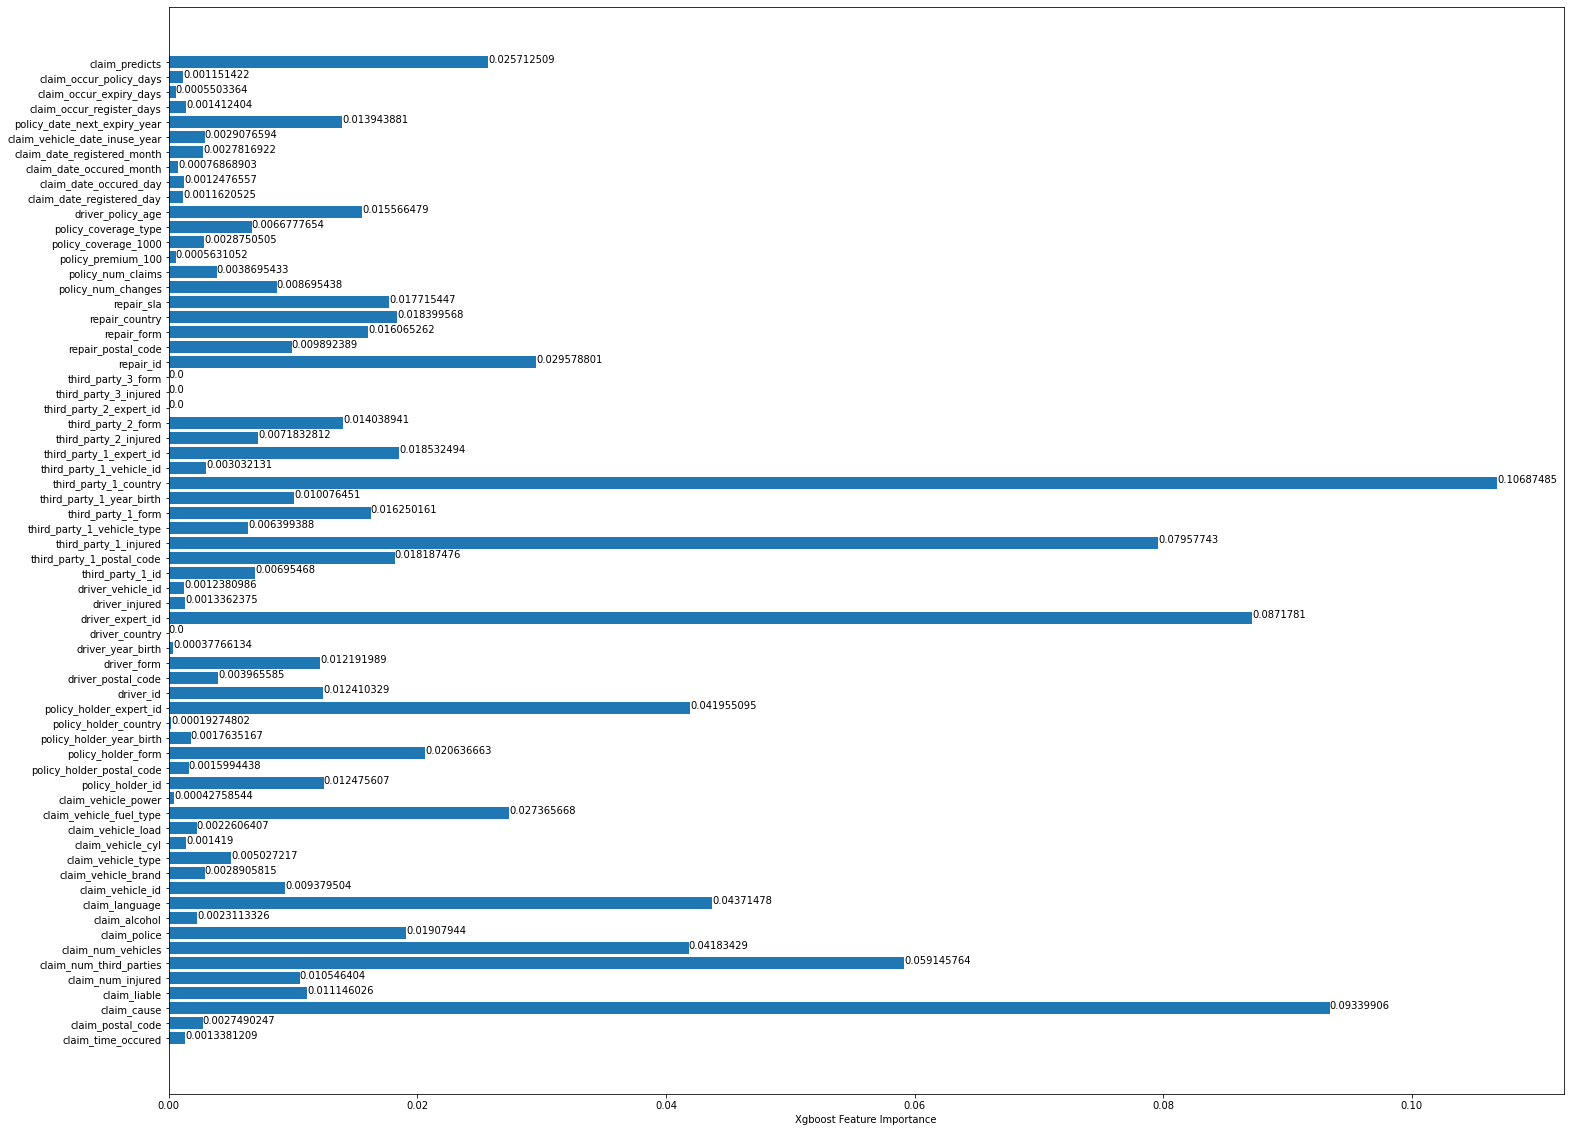

In [61]:
#CRO: visualisation of xgb feature importance

names  = list(train_X_train.columns.values.tolist())
plt.rcParams['figure.figsize'] = [25,20]
plt.barh(names,xgb.feature_importances_)
plt.xlabel("Xgboost Feature Importance")
for index,value in enumerate(xgb.feature_importances_):
  plt.text(value,index,str(value))

#### Light GBM - Optuna

In [180]:
# Optuna Study of LightGBM
## Custom evaluation metric - Coverage

def get_coverage(predict_proba, label_df):
  label_df['fraud_preds'] = predict_proba[:,1]
  top100_frame = label_df.sort_values(by=['fraud_preds'], ascending=False)[0:100] 
  top100_frame_true = top100_frame[top100_frame['fraud'] == 1] 
  coverage_sum = top100_frame_true['claim_amount'].sum()
  print('Total Found:'.ljust(15), coverage_sum)         
  coverage_percent = top100_frame_true['claim_amount'].sum()/(label_df[label_df['fraud'] == 1]['claim_amount'].sum())
  print('Coverage:'.ljust(15), coverage_percent)
  return coverage_sum

def get_coverage_lgbm(predict_proba, label_df):
  label_df['fraud_preds'] = predict_proba
  top100_frame = label_df.sort_values(by=['fraud_preds'], ascending=False)[0:100] 
  top100_frame_true = top100_frame[top100_frame['fraud'] == 1] 
  coverage_sum = top100_frame_true['claim_amount'].sum()
  coverage_percent = top100_frame_true['claim_amount'].sum()/(label_df[label_df['fraud'] == 1]['claim_amount'].sum())
  return coverage_sum

def objective(trial):

    dtrain = lgb.Dataset(X_resampled, label=y_resampled)
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
 
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(train_X_test)
    coverage = get_coverage_lgbm(preds, train_Y_test)

    return coverage
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-05-24 10:45:55,859] A new study created in memory with name: no-name-770be34f-a299-4510-9768-c6b87b4da3e6
[I 2021-05-24 10:46:07,104] Trial 0 finished with value: 253645.43 and parameters: {'lambda_l1': 6.938986597506497e-07, 'lambda_l2': 0.00012354347962065162, 'num_leaves': 219, 'feature_fraction': 0.9895592586689832, 'bagging_fraction': 0.43840336897499277, 'bagging_freq': 4, 'min_child_samples': 52}. Best is trial 0 with value: 253645.43.
[I 2021-05-24 10:46:13,681] Trial 1 finished with value: 252282.63 and parameters: {'lambda_l1': 1.5806964610785697e-08, 'lambda_l2': 4.650049346856663e-06, 'num_leaves': 196, 'feature_fraction': 0.42344278923004175, 'bagging_fraction': 0.40438414812989804, 'bagging_freq': 4, 'min_child_samples': 8}. Best is trial 0 with value: 253645.43.
[I 2021-05-24 10:46:20,213] Trial 2 finished with value: 255142.84 and parameters: {'lambda_l1': 0.22190828907416008, 'lambda_l2': 0.002237498395858533, 'num_leaves': 160, 'feature_fraction': 0.6217776480

Number of finished trials: 100
Best trial: {'lambda_l1': 7.521939295869131, 'lambda_l2': 6.043411700753683e-08, 'num_leaves': 247, 'feature_fraction': 0.8232632720163071, 'bagging_fraction': 0.4816628868437194, 'bagging_freq': 5, 'min_child_samples': 70}


In [185]:
# Fit the model found with best parameters

test_dataframe_compare = test_dataframe[['claim_id', 'test_claim_preds']]
dtrain = lgb.Dataset(X_resampled_full, label=y_resampled_full)
gbm = lgb.train(study.best_trial.params, dtrain)
pred_test_frame = test_dataframe.drop('claim_id', axis = 1)
preds = gbm.predict(pred_test_frame)
test_dataframe_compare['fraud_pred'] = preds

### Submission

In [99]:
#Test data predict claim amounts using Gradient Boosting Trees

test_dataframe['test_claim_preds'] = claim_model.predict(test_dataframe.drop('claim_id', axis = 1))
test_dataframe

,claim_id,claim_time_occured,claim_postal_code,claim_cause,claim_liable,claim_num_injured,claim_num_third_parties,claim_num_vehicles,claim_police,claim_alcohol,claim_language,claim_vehicle_id,claim_vehicle_brand,claim_vehicle_type,claim_vehicle_cyl,claim_vehicle_load,claim_vehicle_fuel_type,claim_vehicle_power,policy_holder_id,policy_holder_postal_code,policy_holder_form,policy_holder_year_birth,policy_holder_country,policy_holder_expert_id,driver_id,driver_postal_code,driver_form,driver_year_birth,driver_country,driver_expert_id,driver_injured,driver_vehicle_id,third_party_1_id,third_party_1_postal_code,third_party_1_injured,third_party_1_vehicle_type,third_party_1_form,third_party_1_year_birth,third_party_1_country,third_party_1_vehicle_id,third_party_1_expert_id,third_party_2_injured,third_party_2_form,third_party_2_expert_id,third_party_3_injured,third_party_3_form,repair_id,repair_postal_code,repair_form,repair_country,repair_sla,policy_num_changes,policy_num_claims,policy_premium_100,policy_coverage_1000,policy_coverage_type,driver_policy_age,claim_date_registered_day,claim_date_occured_day,claim_date_occured_month,claim_date_registered_month,claim_vehicle_date_inuse_year,policy_date_next_expiry_year,claim_occur_register_days,claim_occur_expiry_days,claim_occur_policy_days,test_claim_preds
0,65469,-1.0,7.0,4.0,1.0,0,1,2,0.0,0.0,1.0,0,1.0,1.0,1798.0,1.98,0.0,88.0,0,100.0,1.0,70.0,0.0,1.0,0,8.0,1.0,70.0,0.0,1.0,0.0,20647.0,0,8.0,1.0,4.0,0.0,-1.0,0.0,0,1.0,0.0,3.0,1.0,0.0,3.0,1,74.0,0.0,0.0,1.0,2,2,14.0,33.0,0.0,1,1,30,12,1,5.0,1.0,2,245.0,1581.0,2985.018735
1,65470,-1.0,70.0,4.0,1.0,0,1,3,0.0,0.0,1.0,0,9.0,1.0,1753.0,1.95,1.0,85.0,0,952.0,1.0,36.0,0.0,1.0,0,71.0,0.0,35.0,0.0,1.0,0.0,9700.0,0,80.0,1.0,4.0,0.0,-1.0,0.0,0,1.0,0.0,3.0,1.0,0.0,3.0,0,0.0,3.0,1.0,0.0,0,5,11.0,15.0,0.0,0,1,29,12,1,12.0,1.0,3,307.0,4441.0,2124.358606
2,65471,-1.0,2.0,4.0,1.0,0,1,2,0.0,0.0,1.0,0,11.0,1.0,1248.0,1.58,0.0,62.0,1,227.0,1.0,26.0,0.0,1.0,1,20.0,1.0,26.0,0.0,1.0,0.0,4408.0,0,7.0,1.0,4.0,0.0,-1.0,0.0,0,1.0,0.0,3.0,1.0,0.0,3.0,0,0.0,3.0,1.0,0.0,1,0,11.0,-1.0,0.0,1,1,29,12,1,3.0,1.0,3,246.0,119.0,1957.867323
3,65472,-1.0,6.0,4.0,1.0,0,1,3,0.0,0.0,0.0,0,27.0,1.0,1598.0,1.73,0.0,81.0,0,72.0,1.0,31.0,0.0,1.0,0,7.0,0.0,30.0,0.0,1.0,0.0,8069.0,1,9.0,1.0,4.0,2.0,73.0,0.0,0,1.0,0.0,3.0,1.0,0.0,3.0,0,0.0,3.0,1.0,0.0,4,2,9.0,17.0,0.0,0,1,27,12,1,8.0,1.0,5,36.0,695.0,1908.045902
4,65473,-1.0,54.0,4.0,1.0,0,1,2,0.0,0.0,0.0,0,34.0,1.0,1043.0,1.23,0.0,33.0,0,601.0,1.0,31.0,0.0,1.0,0,46.0,1.0,31.0,0.0,1.0,0.0,19289.0,0,55.0,1.0,4.0,0.0,-1.0,0.0,0,1.0,0.0,3.0,1.0,0.0,3.0,0,0.0,3.0,1.0,0.0,0,3,7.0,-1.0,0.0,1,1,29,12,1,24.0,1.0,3,246.0,2676.0,1567.181808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29950,95422,-1.0,6.0,3.0,0.0,0,0,2,0.0,0.0,1.0,0,23.0,1.0,1198.0,1.42,0.0,59.0,0,71.0,1.0,94.0,0.0,2.0,0,7.0,1.0,94.0,0.0,2.0,0.0,3656.0,0,0.0,0.0,0.0,3.0,-1.0,1.0,0,1.0,0.0,3.0,1.0,0.0,3.0,1,8.0,0.0,0.0,0.0,0,2,8.0,12.0,0.0,1,29,28,12,12,7.0,2.0,1,-575.0,11319.0,4732.074289
29951,95423,-1.0,17.0,4.0,0.0,0,1,4,0.0,0.0,1.0,0,19.0,1.0,2143.0,2.42,1.0,120.0,0,210.0,1.0,43.0,0.0,0.0,0,18.0,1.0,43.0,0.0,0.0,0.0,140.0,1,18.0,1.0,4.0,2.0,-1.0,0.0,0,1.0,0.0,3.0,1.0,0.0,3.0,0,0.0,3.0,1.0,0.0,2,1,6.0,-1.0,0.0,1,29,18,12,12,15.0,2.0,11,-473.0,1934.0,1510.877291
29952,95424,-1.0,19.0,4.0,0.0,1,1,3,0.0,0.0,1.0,0,19.0,1.0,2143.0,2.28,1.0,150.0,0,227.0,0.0,30.0,0.0,0.0,0,20.0,0.0,30.0,0.0,0.0,1.0,583.0,0,20.0,1.0,4.0,2.0,-1.0,0.0,0,1.0,0.0,3.0,1.0,0.0,3.0,1,25.0,0.0,0.0,1.0,1,1,13.0,-1.0,0.0,1,29,29,12,12,9.0,2.0,0,-576.0,941.0,4648.650605
29953,95425,-1.0,46.0,4.0,0.0,0,2,5,0.0,0.0,0.0,0,24.0,1.0,1686.0,2.02,1.0,81.0,0,606.0,1.0,31.0,0.0,0.0,0,47.0,1.0,31.0,0.0,0.0,0.0,12959.0,0,45.0,1.0,4.0,0.0,-1.0,0.0,0,1.0,1.0,2.0,1.0,0.0,3.0,0,0.0,3.0,1.0,0.0,2,2,7.0

In [181]:
# Fit using the full data

X_resampled_full, y_resampled_full = ADASYN().fit_resample(train_X, train_Y['fraud'])
weights = []
counter = 0
for arr in X_resampled_full:
  if (y_resampled_full[counter]==1):
    weights.append(arr[-1]/200)
  else:
    weights.append(arr[-1]/1000)
  counter += 1

In [ ]:
# Fit best classifier & Predict test set

rf = RandomForestClassifier(n_estimators=500)
fraud_model = rf.fit(X_resampled_full, y_resampled_full, weights)
test_cbe['fraud_pred'] = fraud_model.predict_proba(test_cbe.drop('claim_id', axis = 1))[:,1]

In [ ]:
# Top 100 predicted fraudelent claims

top100_frame = test_cbe.sort_values(by=['fraud_pred'], ascending=False)[0:100] 
top100_frame

,claim_postal_code,claim_cause,claim_liable,claim_police,claim_language,claim_vehicle_brand,claim_vehicle_type,claim_vehicle_fuel_type,policy_holder_postal_code,policy_holder_form,policy_holder_country,driver_postal_code,driver_form,driver_country,driver_injured,third_party_1_postal_code,third_party_1_injured,third_party_1_vehicle_type,third_party_1_form,third_party_1_country,repair_postal_code,repair_form,repair_country,repair_sla,claim_time_occured,claim_num_injured,claim_num_third_parties,claim_num_vehicles,claim_vehicle_id,claim_vehicle_cyl,claim_vehicle_load,claim_vehicle_power,policy_holder_id,policy_holder_year_birth,policy_holder_expert_id,driver_id,driver_year_birth,driver_expert_id,driver_vehicle_id,third_party_1_id,third_party_1_year_birth,third_party_1_vehicle_id,repair_id,policy_num_changes,policy_num_claims,policy_premium_100,policy_coverage_1000,policy_coverage_type,driver_policy_age,claim_postal_code_values,policy_holder_postal_values,driver_postal_values,third_party_1_postal_values,repair_postal_values,claim_occur_register_days,claim_occur_expiry_days,claim_occur_policy_days,claim_id,test_claim_preds,fraud_pred
13082,0.014938,0.158765,0.0071,0.014912,0.010508,0.003564,0.005334,0.005972,0.014063,0.006057,0.005546,0.015838,0.005713,0.005543,0.0056,0.012192,0.012953,0.012032,0.012953,0.012953,0.005110,0.005080,0.005080,0.005767,4.248932,-0.222667,-1.421388,0.666266,-0.396984,0.274458,0.374148,0.221498,-0.455394,-0.307236,-2.546272,-0.796595,-0.673813,-2.606183,-0.397446,-0.418158,1.937866,1.046269,0.484019,-0.454926,-0.779830,-0.443477,0.081074,-0.863805,0.796539,-2.191569,-2.074331,-2.206128,1.508213,0.920543,-0.229107,-0.331674,-0.602039,78554.0,8649.034601,1.00
29594,0.013562,0.158765,0.0071,0.014912,0.010508,0.004439,0.005334,0.005972,0.012202,0.004692,0.005546,0.011215,0.005144,0.005543,0.0056,0.012192,0.012953,0.012032,0.012953,0.012953,0.005110,0.005080,0.005080,0.005767,0.301329,-0.222667,-1.421388,1.759735,-0.396984,-0.113707,0.191312,0.126305,-0.455394,-0.506077,-2.271505,-0.796595,-0.886631,-2.389455,-0.397446,-0.030730,0.546718,-0.192284,0.780123,1.567530,-0.391716,1.030757,0.351127,-0.934052,0.796539,-1.970714,-1.864562,-1.978179,1.508213,0.920543,-0.184236,-0.638109,-0.593896,95066.0,9037.921543,1.00
840,0.013005,0.158765,0.0071,0.014912,0.010508,0.004559,0.005334,0.005972,0.012086,0.006057,0.005546,0.012638,0.005713,0.005543,0.0056,0.012192,0.012953,0.012032,0.012953,0.012953,0.011938,0.006156,0.006081,0.005767,-0.379441,-0.222667,-1.421388,0.666266,-0.396984,-0.113707,-0.377510,-0.254465,-0.164553,-0.704918,-2.438327,-0.796595,-1.099448,-2.529279,-0.397446,0.055304,0.407098,-0.154679,-1.019798,-0.454926,-0.779830,1.030757,-0.278996,-0.598333,0.796539,-1.462406,-1.223154,-1.340766,1.508213,-1.135114,-0.244064,-0.751928,-0.335877,66309.0,8669.818184,0.99
5423,0.013005,0.158765,0.0071,0.014912,0.010508,0.004559,0.005334,0.005972,0.012086,0.006057,0.005546,0.012638,0.005713,0.005543,0.0056,0.012192,0.012953,0.012032,0.012953,0.012953,0.005110,0.005080,0.005080,0.005767,-0.501287,-0.222667,-1.421388,0.666266,-0.396984,-0.113707,-0.275934,-0.349658,0.126289,-0.307236,-2.438327,1.255344,-0.673813,-2.529279,-0.397446,0.054945,0.963406,0.155120,1.147356,-0.454926,-0.391716,-0.443477,-0.278996,-1.292181,0.796539,-1.462406,-1.223154,-1.340766,1.508213,0.920543,-0.229107,0.079824,-0.527821,70892.0,8003.712880,0.98
27961,0.013005,0.158765,0.0071,0.014912,0.010508,0.005501,0.005334,0.004435,0.012086,0.004692,0.005546,0.012638,0.005144,0.005543,0.0056,0.012192,0.012953,0.012032,0.012953,0.012953,0.005110,0.005080,0.005080,0.005767,0.396676,-0.222667,-1.421388,0.666266,-0.396984,-0.567428,-0.580660,-0.730429,-0.455394,-0.174676,-2.271505,-0.796595,-0.531935,-2.389455,-0.397446,-0.057256,0.449646,0.061672,1.207069,-0.454926,-0.003602,-0.197771,-0.459031,0.488983,0.796539,-1.462406,-1.223154,-1.340766,1.508213,0.920543,-0.259020,0.981617,-0.552018,93433.0,7724.842353,0.97
11342,0.007631,0.158765,0.0071,0.014912,0.0

In [ ]:
# Export to CSV

test_dataframe_export = test_cbe[['claim_id', 'fraud_pred']]
test_dataframe_export.to_csv('predictions.csv', header = None, sep = ',', index=False)

## **Post-Assessment (Hidden Dataframe)**

In [187]:
# Load the hiddent dataframe
hidden_df = pd.read_csv('hidden.csv')

# Calculate the top 100 claim amount sum - Hidden csv

test_top_100 = test_dataframe_compare.sort_values(by='fraud_pred', ascending = False)[0:100]
hidden_claims = hidden_df[hidden_df['claim_id'].isin(list(test_top_100.claim_id))]
print('Top 100 Reclaim: ', hidden_claims[hidden_claims['fraud'] == 'Y']['claim_amount'].sum())

# Calculate the AUC

hidden_claims_arr  = hidden_df.sort_values(by = 'claim_id')['fraud'].apply(lambda z: 0 if(z == 'N') else 1)
fpr, tpr, thresholds = metrics.roc_curve(hidden_claims_arr.to_numpy(), preds)
print('AUC: ', metrics.auc(fpr, tpr))

Top 100 Reclaim:  720586.5199999999
AUC:  0.7545258734923792


In [183]:
# Load the hiddent dataframe - Post Assessment

hidden_df = pd.read_csv('hidden.csv')
predictions = pd.read_csv('predictions_4.csv', header = None)
predictions.columns = ['claim_id', 'fraud_preds']

# Calculate the top 100 claim amount sum - Hidden csv

test_top_100 = predictions.sort_values(by='fraud_pred', ascending = False)[0:100]
hidden_claims = hidden_df[hidden_df['claim_id'].isin(list(test_top_100.claim_id))]
print('Top 100 Reclaim: ', hidden_claims[hidden_claims['fraud'] == 'Y']['claim_amount'].sum())

# Calculate the AUC

hidden_claims_arr  = hidden_df.sort_values(by = 'claim_id')['fraud'].apply(lambda z: 0 if(z == 'N') else 1)
fpr, tpr, thresholds = metrics.roc_curve(hidden_claims_arr.to_numpy(), preds)
print('AUC: ', metrics.auc(fpr, tpr))

Top 100 Reclaim:  671168.9899999999
AUC:  0.8153793620957246
